# Weighing the evidence in SWRs
_Scott Linderman_ \\
_January 24, 2022_

---

Imagine you are navigating a large Scandinavian furniture store. 
You find yourself in the _Children's Rooms_ section with who knows how many miles to go before checkout.
It didn't seem to take so long last time you were here...
You recall weaving your way through _Kitchen and Dining_ into _Home Office_ and _Children's Rooms_, and then you remember.
There was a shortcut, hidden behind a brown-black lacquered wardrobe, that led straight to the exit!

What neural mechanisms might facilitate the recollection of past experiences and the formation of mental models of the environment?
Rodents performing spatial navigation tasks, albeit in less enriched environments, seem to perform similar mental computations.
As animals move through their environment, place cells in the hippocampus fire in a spatially localized manner to represent the animal's current location. 
Every so often, when the animal pauses, there are brief bursts of spiking activity in the hippocampus known as sharp-wave ripples~(SWRs).
In a fraction of SWRs, the burst involves a sequence of spikes across neurons with adjacent place fields.
In other words, some SWRs seem to correspond to mental simulation, or ``replay,'' of trajectories through space. 

Surprisingly, previous work suggested that only a fraction ($\sim$25\%) of SWRs constitute replay of trajectories [(Pfeiffer and Foster, 2015)](https://pubmed.ncbi.nlm.nih.gov/26160946/). 
In a paper in this issue, [Krause and Drugowitsch (2022)](https://pubmed.ncbi.nlm.nih.gov/34863366/)  hypothesized that the remaining SWRs might also encode spatial trajectories, but that previous methods for classifying SWRs were overly restrictive.
For example, previous methods placed strict constraints on the inferred velocity profile or distance traveled in order for an SWR to be considered a trajectory.
To address this limitation, Krause and Drugowitsch (2022) developed a novel method for classifying SWRs based on state space models and Bayesian model comparison, using what statisticians call the _model evidence_


## Setup

In [1]:
!pip install -q git+https://github.com/lindermanlab/ssm-jax-refactor.git

In [2]:
import warnings

import ssm.hmm
import jax.numpy as np
import jax.random as jr
from tensorflow_probability.substrates import jax as tfp

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.cm import Blues, Reds, Greens, Purples, Greys
import seaborn as sns
sns.set_context("paper")

## Build the random and diffusion models

In [3]:
# Construct the random number generator for reproducibility
rng = jr.PRNGKey(0)

# Specify the environment 
grid_size = 10
bin_edges = np.arange(grid_size+1)
grid_pts = (bin_edges[:-1] + bin_edges[1:]) / 2
grid = np.meshgrid(grid_pts, grid_pts)
grid_xy = np.column_stack([g.ravel() for g in grid])

# Make a denser grid for contour plots
dense_grid = np.meshgrid(np.linspace(0, grid_size), np.linspace(0, grid_size))
dense_grid_xy = np.column_stack([g.ravel() for g in dense_grid])

# Specify the place fields and the expected spikes at each location
rng, this_rng = jr.split(rng, 2)
num_neurons = 50
place_field_width = 1 * np.ones(2)
place_field_centers = jr.uniform(this_rng, shape=(num_neurons, 2), 
                                 minval=0, maxval=grid_size)
place_field_amp = 20 
rates = place_field_amp * tfp.distributions.MultivariateNormalDiag(
    place_field_centers, place_field_width).prob(
        grid_xy[:, None, :]) + 0.25


# Evaluate rates on the dense grid for plotting
dense_rates = place_field_amp * tfp.distributions.MultivariateNormalDiag(
    place_field_centers, place_field_width).prob(
        dense_grid_xy[:, None, :])  + 0.15


# Specify the random transition matrix
P_random = np.ones((grid_size**2, grid_size**2)) / grid_size**2

# Specify the diffusion model transition matrix
P_diffusion = np.exp(-0.5 * np.sum((grid_xy[:, None, :] - grid_xy[None, :, :])**2, axis=-1) / 0.5**2)
P_diffusion = P_diffusion.at[np.arange(grid_size**2), np.arange(grid_size**2)].set(1e-3)
P_diffusion /= P_diffusion.sum(axis=1, keepdims=True)

In [4]:
# Build the random and diffusion models with SSM
random_model = ssm.hmm.PoissonHMM(
    num_states=grid_size**2,
    num_emission_dims=num_neurons,
    initial_state_probs=np.ones(grid_size**2) / grid_size**2,
    transition_matrix=P_random,
    emission_rates=rates
)

diffusion_model = ssm.hmm.PoissonHMM(
    num_states=grid_size**2,
    num_emission_dims=num_neurons,
    initial_state_probs=np.ones(grid_size**2) / grid_size**2,
    transition_matrix=P_diffusion,
    emission_rates=rates
)

## Sample the diffusion model

Note: this can take a few seconds since under the hood SSM uses JAX, which compiles the sampling code. That's good if we're sampling a lot, but slow if we're only sampling once, like we are here.

In [5]:
rng = jr.PRNGKey(124)
num_steps = 10

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    states, spikes = diffusion_model.sample(num_steps=num_steps, key=rng)

# Convert the states from (0,..,99) to (x,y) coordinates in the 10x10 grid
states_y, states_x = np.unravel_index(states, (grid_size, grid_size))

# Compute some summary statistics for later
num_spikes = spikes.sum()

## Compute the model evidence and the fraction of deviance explained

In [6]:
# Compute likelihood under the two SSMs
diffusion_ll = diffusion_model.marginal_likelihood(spikes)
random_ll = random_model.marginal_likelihood(spikes)

# Compute log likelihood under the null model
avg_rate = np.mean(rates, axis=0)
null_ll = tfp.distributions.Poisson(avg_rate).log_prob(spikes).sum()

# Compute the log likelihood under the saturated models
sat_ll = tfp.distributions.Poisson(spikes).log_prob(spikes).sum()

# Compute the fraction of deviance explained
print("Fraction of deviance explained:")
print("diffusion: ", 1 - (sat_ll - diffusion_ll) / (sat_ll - null_ll))
print("random:    ", 1 - (sat_ll - random_ll) / (sat_ll - null_ll))

Fraction of deviance explained:
diffusion:  0.1983316
random:     0.1265307


## Make the figure for the paper

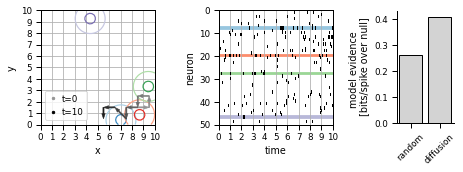

In [7]:
fig = plt.figure(figsize=(6.5, 2.5))
gs = GridSpec(1, 3, width_ratios=(1, 1, 0.5))
neurons = [7, 19, 27, 46]
cmaps = [Blues, Reds, Greens, Purples]

# A. Plot the environment and a few place fields
ax0 = fig.add_subplot(gs[0,0])
for n, cmap in zip(neurons, cmaps):
    plt.contour(*dense_grid, dense_rates[:, n].reshape(50, 50), 2, cmap=cmap)

for t in range(num_steps):
    # plt.plot(states_x[t:t+2] + 0.5, states_y[t:t+2] + 0.5, 
    #          '-', marker='.', lw=2, color=Greys(0.5+t/num_steps*0.5))
    plt.arrow(states_x[t] + 0.5, states_y[t] + 0.5, 
              states_x[t+1] - states_x[t], states_y[t+1] - states_y[t],
              width=0.1, length_includes_head=True, zorder=3,
              lw=0.5, color=Greys(0.5+t/num_steps*0.5))

# Plot dummy points for start and stop
plt.plot([np.nan], [np.nan], '.', lw=2, color=Greys(0.5), label="t=0")
plt.plot([np.nan], [np.nan], '.', lw=2, color='k', label="t=10")
plt.legend(loc="lower left", handlelength=1, handletextpad=0.5)

# Set the axis limits, etc.
ax0.set_aspect(1)
plt.xticks(bin_edges)
plt.xlim(0, grid_size)
plt.xlabel("x")
plt.yticks(bin_edges)
plt.ylim(0, grid_size)
plt.ylabel("y")
plt.grid(True)

# B. Plot the spike train
ax1 = fig.add_subplot(gs[0,1])
rng = jr.PRNGKey(0)

for n, spks in enumerate(spikes.T):
    spk_times = np.repeat(np.arange(10), spks.astype(int))
    if len(spk_times) == 0:
        continue

    this_rng, rng = jr.split(rng, 2)
    spk_times = spk_times + jr.uniform(this_rng, (len(spk_times),))

    for t in spk_times:
        plt.plot([t, t], [n, n+1], '-', color='k', lw=1)

# Highlight the rows from panel a
for (n, cmap) in zip(neurons, cmaps):
    plt.fill_between([0, 10], n, n+1, color=cmap(100), alpha=1)

# Set the axis limits, etc.
plt.xticks(np.arange(11))
plt.grid(axis='x')  
plt.xlim(0, 10)
plt.ylim(num_neurons, 0)
plt.xlabel("time")
plt.ylabel("neuron")
ax1.set_aspect(.2)

# C. Plot the model evidence in bits per spike over null model
ax2 = fig.add_subplot(gs[0, 2])
to_bps = lambda ll: (ll - null_ll) / num_spikes / np.log(2)
plt.bar([0, 1], [to_bps(random_ll), to_bps(diffusion_ll)],
        color='lightgray', ec='k', lw=1, alpha=1)

plt.ylabel('model evidence \n [bits/spike over null]')
plt.xticks([0, 1], ['random', 'diffusion'], rotation=45)
ax2.set_aspect(9)
sns.despine(ax=ax2)

# Tighten it up and save
plt.tight_layout()
plt.savefig("figure1.pdf")